# Monte Carlo Simulation of a locked token (spot + perps)

## Simulation function

This is the main function that governs the MC strategy. It includes Binance's risk tiers (need to be inputted manually if we test different shitcoin in the TEST RUN section for now in the manual_eos_tiers - yes, I am lazy to rename). The idea is to simulate prices weekly (do note that the main price simulation setting happens in the MC section, here we just modify our outlook on the price. The degrees of freedom etc are just a fallback in case there are no inputs in the MC function later on).

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t
import requests  

try:
    import numpy_financial as npf
except ImportError:
    npf = None

def get_required_margin(notional, maint_data):
    """
    Given a notional and a list of maintenance margin tiers (maint_data),
    compute the required margin using the tier formula:
    
        tier_margin = max(notional * maintMarginRate - maintAmount, 0)
    
    Then, compare this with the default margin (1/3 of the notional)
    and return the higher value.
    
    The function determines the appropriate tier by checking where
    notional falls within [notionalFloor, notionalCap). If notional exceeds
    all tiers, the last tier is used.
    """
    for tier in maint_data:
        if tier["notionalFloor"] <= notional < tier["notionalCap"]:
            tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
            default_margin = notional / 3.0
            return max(tier_margin, default_margin)
    # If notional exceeds all tiers, use the last tier.
    tier = maint_data[-1]
    tier_margin = max(notional * tier["maintMarginRate"] - tier["maintAmount"], 0.0)
    default_margin = notional / 3.0
    return max(tier_margin, default_margin)

def simulate_strategy_weekly(
    P0, investment_amount, discount, hedge_ratio, T, annual_vol, annual_funding_rate,
    cliff_weeks=0, price_floor=None, seed=None, external_shocks=None, maint_margin_data=None,
    staking_apy=0.0, sell_frequency="weekly"  # <--- added
):
    if seed is not None:
        np.random.seed(seed)

    Q = investment_amount / (P0 * (1 - discount))

    # Price simulation setup
    price_outlook = "bearish"
    outlook_drifts = {"bearish": -0.45, "neutral": 0.00, "bullish": 0.10}
    mu = np.log(1 + outlook_drifts.get(price_outlook, 0.0))
    dt = 1 / 52.0
    total_weeks = T
    prices = [P0]
    df_t = 5.0
    skew_strength = 0.5

    if external_shocks is not None:
        shocks = external_shocks
    else:
        shocks = student_t.rvs(df_t, size=total_weeks)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))

    for Z in shocks:
        last_price = prices[-1]
        Pt = last_price * np.exp((mu - 0.5 * annual_vol**2) * dt + annual_vol * np.sqrt(dt) * Z)
        prices.append(max(Pt, price_floor) if price_floor is not None else Pt)

    # Initial setup
    details = []
    collateral_series = []

    token_cost = Q * P0 * (1 - discount)
    hedged_tokens = hedge_ratio * Q

    if maint_margin_data is not None:
        initial_required = get_required_margin(hedged_tokens * P0, maint_margin_data)
    else:
        initial_required = (1/3) * (hedged_tokens * P0)

    initial_collateral = initial_required
    cf0 = -token_cost - initial_collateral

    details.append({
        "time": 0.0, "week": 0, "price": P0,
        "remaining_long": Q, "remaining_short": hedged_tokens,
        "collateral": initial_collateral, "collateral_flow": -initial_collateral,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0, "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0, "vesting_total_flow": 0.0,
        "staking_tokens_tokens": 0.0,
        "total_cf": cf0, "note": "Initial Setup"
    })

    remaining_long = Q
    remaining_short = hedged_tokens
    collateral = initial_collateral
    total_funding_cost = 0.0

    vest_weeks = max(total_weeks - cliff_weeks, 1)
    vest_per_week = Q / vest_weeks

    accumulated_vested = 0.0

    for t in range(1, total_weeks + 1):
        time_year = t / 52.0
        price_prev = prices[t - 1]
        current_price = prices[t]

        notional = remaining_short * price_prev
        if maint_margin_data is not None:
            new_collateral_required = get_required_margin(notional, maint_margin_data)
        else:
            new_collateral_required = notional / 3.0

        collateral_change = new_collateral_required - collateral
        collateral_flow = -collateral_change
        collateral = new_collateral_required
        collateral_series.append(collateral)

        funding_cost = (annual_funding_rate / 52.0) * notional
        total_funding_cost += funding_cost

        # Staking Rewards
        staking_reward = (staking_apy / 52.0) * remaining_long 
        remaining_long += staking_reward

        # Vesting Logic
        if t > cliff_weeks:
            vested = vest_per_week
        else:
            vested = 0.0

        accumulated_vested += vested
        sell_this_week = False

        if sell_frequency == "weekly":
            sell_this_week = vested > 0
        elif sell_frequency == "monthly":
            if t % 4 == 0 or t == total_weeks:  # Sell at end of every 4 weeks
                sell_this_week = accumulated_vested > 0

        if sell_this_week:
            tokens_hedged_vesting = min(accumulated_vested, remaining_short)
            hedged_sale_flow = tokens_hedged_vesting * current_price
            hedged_cover_flow = tokens_hedged_vesting * (P0 - current_price)
            net_hedged = hedged_sale_flow + hedged_cover_flow

            tokens_unhedged = accumulated_vested - tokens_hedged_vesting
            unhedged_sale_flow = tokens_unhedged * current_price
            vesting_total_flow = net_hedged + unhedged_sale_flow

            remaining_short -= tokens_hedged_vesting
            remaining_long -= accumulated_vested

            accumulated_vested = 0.0
        else:
            hedged_sale_flow = 0.0
            hedged_cover_flow = 0.0
            unhedged_sale_flow = 0.0
            vesting_total_flow = 0.0

        total_cf_week = collateral_flow + funding_cost + vesting_total_flow

        details.append({
            "time": time_year, "week": t, "price": current_price,
            "remaining_long": remaining_long, "remaining_short": remaining_short,
            "collateral": collateral, "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cost,
            "hedged_sale_flow": hedged_sale_flow,
            "hedged_cover_flow": hedged_cover_flow,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "staking_tokens_tokens": staking_reward,
            "total_cf": total_cf_week,
            "note": f"Week {t} - vested: {vested:.2f}, accumulated: {accumulated_vested:.2f}"
        })

    # Final Settlement
    final_time = total_weeks / 52.0
    final_price = prices[-1]
    final_sale = remaining_long * final_price
    final_short_settlement = remaining_short * (P0 - final_price) if remaining_short > 0 else 0.0
    collateral_release = collateral
    final_total_cf = final_sale + final_short_settlement + collateral_release

    details.append({
        "time": final_time, "week": total_weeks, "price": final_price,
        "remaining_long": 0.0, "remaining_short": 0.0, "collateral": 0.0,
        "collateral_flow": collateral_release,
        "funding_cash_flow": 0.0,
        "hedged_sale_flow": 0.0,
        "hedged_cover_flow": final_short_settlement,
        "unhedged_sale_flow": final_sale,
        "vesting_total_flow": final_sale + final_short_settlement,
        "staking_tokens_tokens": 0.0,
        "total_cf": final_total_cf,
        "note": "Final Settlement"
    })

    # IRR calculation
    cash_flows = [(row["time"], row["total_cf"]) for row in details]
    values_arr = np.array([cf for t, cf in cash_flows])
    irr = npf.irr(values_arr) if npf else None
    weekly_irr = irr
    annual_irr = (1 + weekly_irr)**52 - 1 if weekly_irr is not None else None
    total_pnl = np.sum(values_arr)
    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "collateral_series": collateral_series,
        "cash_flows": cash_flows,
        "IRR": irr,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details,
        "Annualized IRR": annual_irr
    }



###############################################################################
# 4) TEST RUN
###############################################################################
if __name__ == "__main__":
    # Manually defined maintenance margin tiers from Binance - will be used in the below Monte Carlo too (https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin)
    manual_eosusdt_tiers = [
        {"notionalFloor": 0,             "notionalCap": 20_000,        "maintMarginRate": 0.0050, "maintAmount": 0},
        {"notionalFloor": 20_000,        "notionalCap": 100_000,       "maintMarginRate": 0.0065, "maintAmount": 30},
        {"notionalFloor": 100_000,       "notionalCap": 800_000,       "maintMarginRate": 0.0100, "maintAmount": 380},
        {"notionalFloor": 800_000,       "notionalCap": 4_000_000,     "maintMarginRate": 0.0200, "maintAmount": 8_380},
        {"notionalFloor": 4_000_000,     "notionalCap": 8_000_000,     "maintMarginRate": 0.0250, "maintAmount": 28_380},
        {"notionalFloor": 8_000_000,     "notionalCap": 40_000_000,    "maintMarginRate": 0.0500, "maintAmount": 228_380},
        {"notionalFloor": 40_000_000,    "notionalCap": 80_000_000,    "maintMarginRate": 0.1000, "maintAmount": 2_228_380},
        {"notionalFloor": 80_000_000,    "notionalCap": 100_000_000,   "maintMarginRate": 0.1250, "maintAmount": 4_228_380},
        {"notionalFloor": 100_000_000,   "notionalCap": 200_000_000,   "maintMarginRate": 0.2500, "maintAmount": 16_728_380},
        {"notionalFloor": 200_000_000,   "notionalCap": 400_000_000,   "maintMarginRate": 0.5000, "maintAmount": 66_728_380},
    ]


    
    results = simulate_strategy_weekly(
        P0=150,                    # initial token price
        investment_amount=5_000_000,  # total cash to invest
        discount=0.2,                # discount (e.g., 40%)
        hedge_ratio=1,                # hedge ratio (fully hedged)
        T=3*52,                       #full ivesting period (e.g. 3 years)
        annual_vol=1.00,              # annualized volatility (100%)
        annual_funding_rate=-0.1,     # -10% annual funding cost (considered as static)
        cliff_weeks=0,              # vesting starts after 12 months
        seed=42,                      # for reproducibility - is replaced in MC simulation
        price_floor=None,             # no price floor
        maint_margin_data=manual_eosusdt_tiers,
        staking_apy=0.05,
        sell_frequency="monthly"  # use the manual tier data
    )

    print("=== Simulation Results ===")
    print("Annualized IRR:", results["Annualized IRR"])
    print("Total PnL:", results["Total_PnL"])
    print("\n--- Monthly Simulation Details ---")
    print(results["simulation_details"])
    print("\n--- Price Path ---")
    print(results["prices"])
    print("\n--- Cash Flows (time in years, cash) ---")
    for t, cf in results["cash_flows"]:
        print(f"t = {t:.2f} years: {cf:.2f}")


=== Simulation Results ===
Annualized IRR: 2.142654537982192
Total PnL: 569477431.0953028

--- Monthly Simulation Details ---
         time  week          price  remaining_long  remaining_short  \
0    0.000000     0     150.000000    41666.666667     41666.666667   
1    0.019231     1     160.724942    41706.730769     41666.666667   
2    0.038462     2     148.532776    41746.833395     41666.666667   
3    0.057692     3     180.299990    41786.974581     41666.666667   
4    0.076923     4     169.522952    40758.778296     40598.290598   
5    0.096154     5     183.100292    40797.969429     40598.290598   
6    0.115385     6     234.051781    40837.198246     40598.290598   
7    0.134615     7     208.730476    40876.464782     40598.290598   
8    0.153846     8     198.326067    39847.393007     39529.914530   
9    0.173077     9     188.394995    39885.707808     39529.914530   
10   0.192308    10     179.748141    39924.059450     39529.914530   
11   0.211538    11   

## Monte Carlo Simulation
A bit messy input - will be improved. The idea here is to take some statistical model (normal, student_t, student skewed or jump difussion) and use that to govern the price generation (we do a sanity check later when we print out a graph of all the price paths). This setup is done in Shock Model Params section. Sensitivity setup allows to run multiple scenarios. The main inputs are given as inputs in the simulate_strategy_weekly function in "Batched Simulation" section.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import t as student_t
from datetime import datetime


def generate_shocks(
    size=156,
    model="student_t_skewed",
    df=4.0,
    skew=-0.5,
    jump_prob=0.003,
    jump_std=0.75,
    clip_std=2.5
):
    if model == "normal":
        shocks = np.random.normal(0, 1, size)
    elif model == "student_t":
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
    elif model == "student_t_skewed":
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew), shocks * (1 - skew))
    elif model == "jump_diffusion":
        shocks = np.random.normal(0, 1, size)
        jumps = np.random.binomial(1, jump_prob, size) * np.random.normal(0, jump_std, size)
        shocks += jumps
    elif model == "student_t_skewed_jump":
        # Realistic combined skewed t + jump diffusion
        shocks = student_t.rvs(df, size=size)
        shocks /= np.sqrt(df / (df - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew), shocks * (1 - skew))
        jumps = np.random.normal(0, jump_std, size) * (np.random.rand(size) < jump_prob)
        shocks += jumps
    else:
        raise ValueError(f"Unknown shock model: {model}")

    # Clip extremes
    if clip_std is not None:
        shocks = np.clip(shocks, -clip_std, clip_std)

    # Explicit drift neutralization
    #shocks -= np.mean(shocks)

    return shocks



# === Sensitivity Setup === #
discounts = np.linspace(0.25, 0.15, 3)
hedge_ratios = np.linspace(0.25, 1, 5)
funding_rates = np.linspace(-0.2, 0.2, 5)
num_runs = 10000
today = datetime.today()  # gets today's date
final_date = datetime(2028, 1, 31)  # you can input your final date here
delta = final_date - today
T = int(delta.days / 7)


# === Shock Model Parameters === #
shock_model = "student_t_skewed_jump"  
shock_params = {
    "model": shock_model,
    "df": 4.0,
    "skew": 0.2,
    "jump_prob": 0.001,
    "jump_std": 0.1,
    "clip_std": 3.0,
    "size": T
}

# === Pre-generate Shocks === #
common_shocks = {
    run: generate_shocks(**shock_params)
    for run in range(num_runs)
}

# === Task Batching === #
batch_size = 100
tasks = []
for discount in discounts:
    for hedge_ratio in hedge_ratios:
        for funding_rate in funding_rates:
            for i in range(0, num_runs, batch_size):
                run_batch = list(range(i, min(i + batch_size, num_runs)))
                tasks.append((discount, hedge_ratio, funding_rate, run_batch))

total_batches = len(tasks)
print("Total batches:", total_batches)

# === Batched Simulation === #
def run_simulation_batch(discount, hedge_ratio, funding_rate, run_batch):
    results = []
    for run in run_batch:
        external_shocks = common_shocks[run]
        res = simulate_strategy_weekly(
            P0=148,
            investment_amount=5_000_000,
            discount=discount,
            hedge_ratio=hedge_ratio,
            T=T,
            annual_vol=0.8,
            annual_funding_rate=funding_rate,
            cliff_weeks=0,
            price_floor=60, #150m FDV
            seed=None,
            external_shocks=external_shocks,
            maint_margin_data=manual_eosusdt_tiers,
            staking_apy=0.05,
            sell_frequency="monthly"  
        )
        results.append((
            discount,
            hedge_ratio,
            funding_rate,
            res["Annualized IRR"],
            res["Total_PnL"],
            res["prices"],
            res["collateral_series"]
        ))
    return results

# === Parallel Execution === #
batched_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_simulation_batch)(discount, hedge_ratio, funding_rate, run_batch)
    for discount, hedge_ratio, funding_rate, run_batch in tqdm(tasks, desc="MC Batches", total=total_batches)
)

results_raw = [item for batch in batched_results for item in batch]

# === Aggregate Results === #
detailed_ann_irr = defaultdict(list)
detailed_pnl = defaultdict(list)
detailed_prices = defaultdict(list)
detailed_collateral = defaultdict(list)

for discount, hedge_ratio, funding_rate, ann_irr, pnl, prices, collateral in results_raw:
    key = (round(discount, 3), round(hedge_ratio, 3), round(funding_rate, 3))
    detailed_ann_irr[key].append(ann_irr)
    detailed_pnl[key].append(pnl)
    detailed_prices[key].append(prices)
    detailed_collateral[key].append(collateral)

results_list = []
for key in detailed_ann_irr:
    disc, hedg, fund = key
    irr_list = [x for x in detailed_ann_irr[key] if x is not None]
    pnl_list = detailed_pnl[key]
    
    avg_ann_irr = np.mean(irr_list) if irr_list else np.nan
    med_ann_irr = np.median(irr_list) if irr_list else np.nan
    avg_pnl = np.mean(pnl_list) if pnl_list else np.nan
    med_pnl = np.median(pnl_list) if pnl_list else np.nan
    
    results_list.append({
        "discount": disc,
        "hedge_ratio": hedg,
        "funding_rate": fund,
        "avg_Annualized_IRR": avg_ann_irr,
        "median_Annualized_IRR": med_ann_irr,
        "avg_Total_PnL": avg_pnl,
        "median_Total_PnL": med_pnl,
        "num_runs": num_runs
    })

results_df = pd.DataFrame(results_list)




Total batches: 7500


MC Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Select the parameter key to inspect.
selected_key = (0.35, 0.4, 0.0)  # adjust as needed

# Retrieve all price paths for that key.
price_paths = detailed_prices[selected_key]

# Flatten all the price values across all runs and time steps.
all_prices = np.concatenate(price_paths)

# Compute descriptive statistics across all prices.
mean_price    = np.mean(all_prices)
median_price  = np.median(all_prices)
min_price     = np.min(all_prices)
max_price     = np.max(all_prices)
std_price     = np.std(all_prices)
p5            = np.percentile(all_prices, 5)
p95           = np.percentile(all_prices, 95)

# Print out the statistics.
print("--- Simulated Price Stats (All Runs & All Time) ---")
print(f"Mean price     : {mean_price:.4f}")
print(f"Median price   : {median_price:.4f}")
print(f"Min price      : {min_price:.4f}")
print(f"Max price      : {max_price:.4f}")
print(f"Std deviation  : {std_price:.4f}")
print(f"5th percentile : {p5:.4f}")
print(f"95th percentile: {p95:.4f}")
# Plot common price paths from the pre-generated shocks:
plt.figure(figsize=(10, 5))
for run in range(len(detailed_prices[(selected_key)])):  # or a subset if you prefer
    # Get a price path from one simulation using the common shocks
    # (Assume using one parameter combination, e.g., key=(0.35, 0.8, 0.0))
    prices = detailed_prices[selected_key][run]
    plt.plot(prices, alpha=0.5)
plt.title("Simulated Price Paths")
avg_path = np.mean(price_paths, axis=0)
plt.plot(avg_path, label='Average Path', linewidth=3, color='black')
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: need at least one array to concatenate

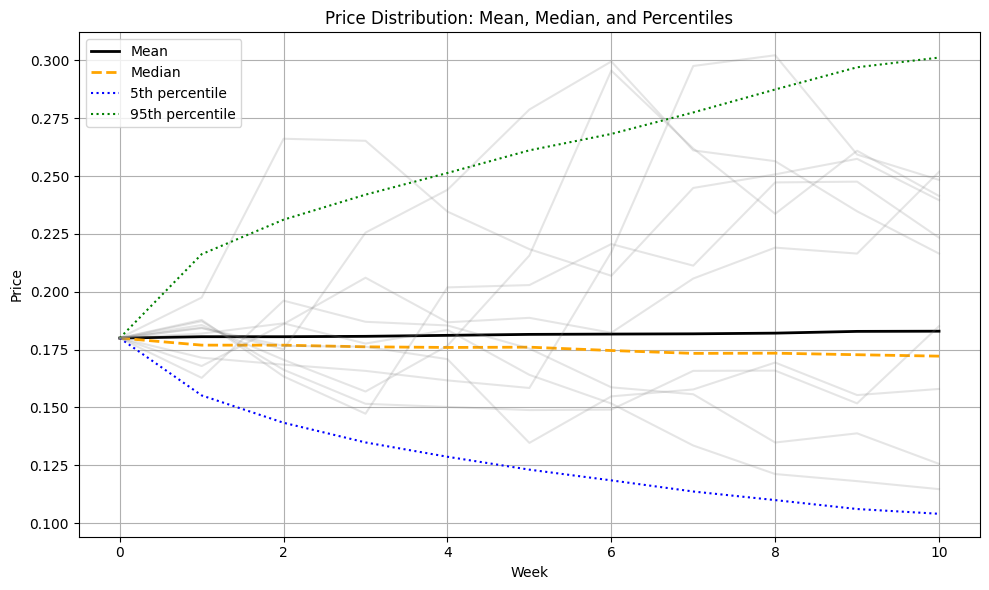

In [10]:
price_matrix = np.array(price_paths)
avg_path = np.mean(price_matrix, axis=0)
median_path = np.median(price_matrix, axis=0)
p5 = np.percentile(price_matrix, 5, axis=0)
p95 = np.percentile(price_matrix, 95, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_path, label='Mean', linewidth=2, color='black')
plt.plot(median_path, label='Median', linewidth=2, linestyle='--', color='orange')
plt.plot(p5, label='5th percentile', linestyle=':', color='blue')
plt.plot(p95, label='95th percentile', linestyle=':', color='green')

# Optional: some sample paths too
for i in range(10):
    plt.plot(price_matrix[i], alpha=0.2, color='gray')

plt.title("Price Distribution: Mean, Median, and Percentiles")
plt.xlabel("Week")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

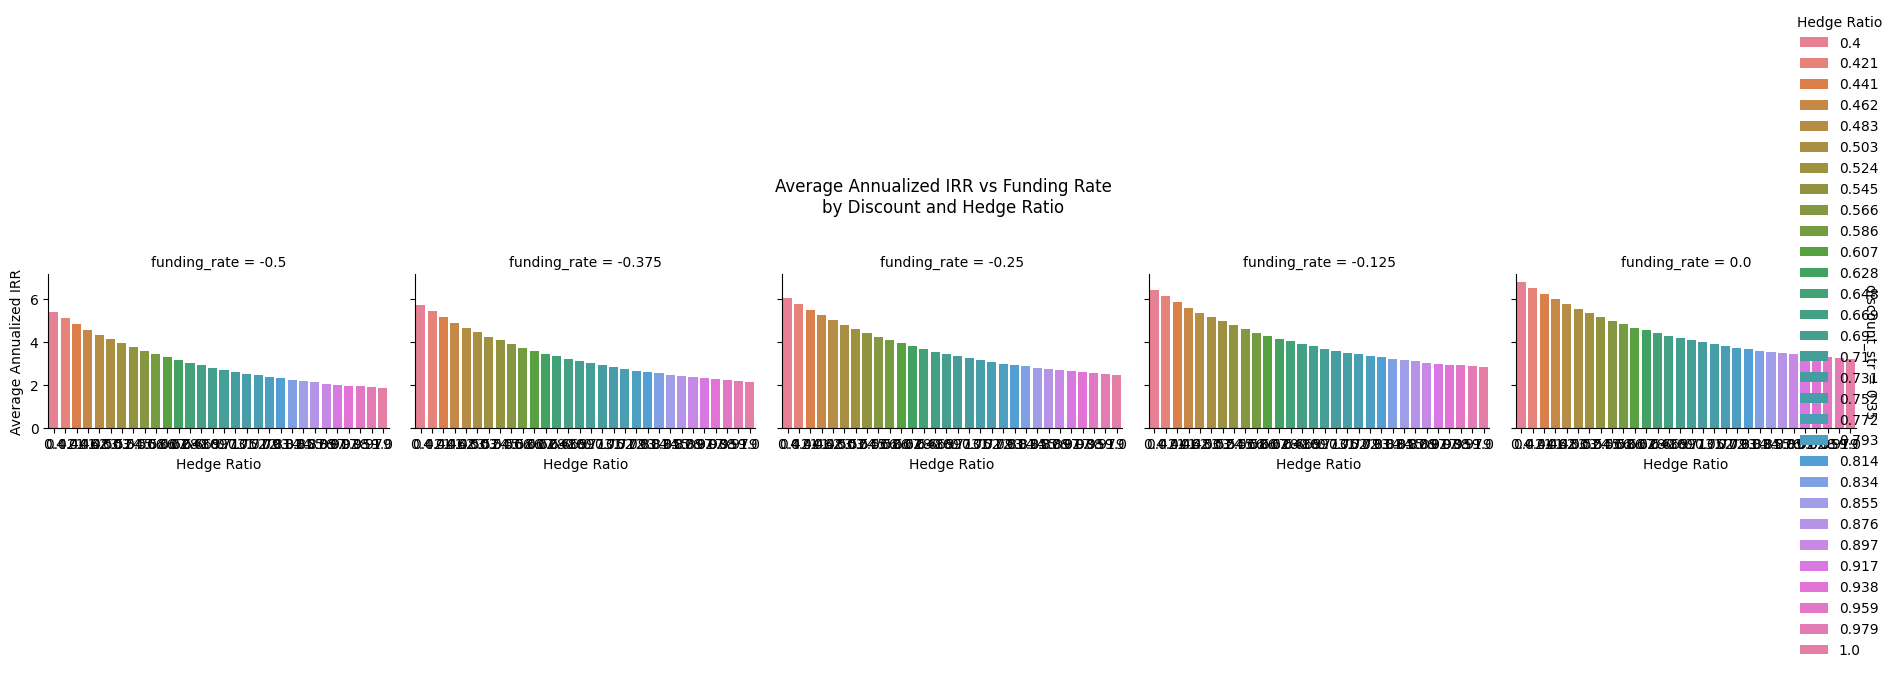

In [11]:
import seaborn as sns
# Ensure discount, hedge_ratio, and funding_rate are available.
results_df['discount_str'] = results_df['discount'].astype(str)
results_df['hedge_ratio_str'] = results_df['hedge_ratio'].astype(str)
results_df['funding_rate'] = pd.to_numeric(results_df['funding_rate'], errors='coerce')

# Create a FacetGrid: each row for a discount, and each column for a funding rate.
g = sns.FacetGrid(results_df, row="discount_str", col="funding_rate", hue="hedge_ratio_str", height=3, aspect=1.2, margin_titles=True)
g.map(sns.barplot, "hedge_ratio_str", "avg_Annualized_IRR", order=sorted(results_df['hedge_ratio_str'].unique()))
g.add_legend(title="Hedge Ratio")
g.set_axis_labels("Hedge Ratio", "Average Annualized IRR")
g.fig.suptitle("Average Annualized IRR vs Funding Rate\nby Discount and Hedge Ratio", y=1.03)
plt.tight_layout()
plt.show()

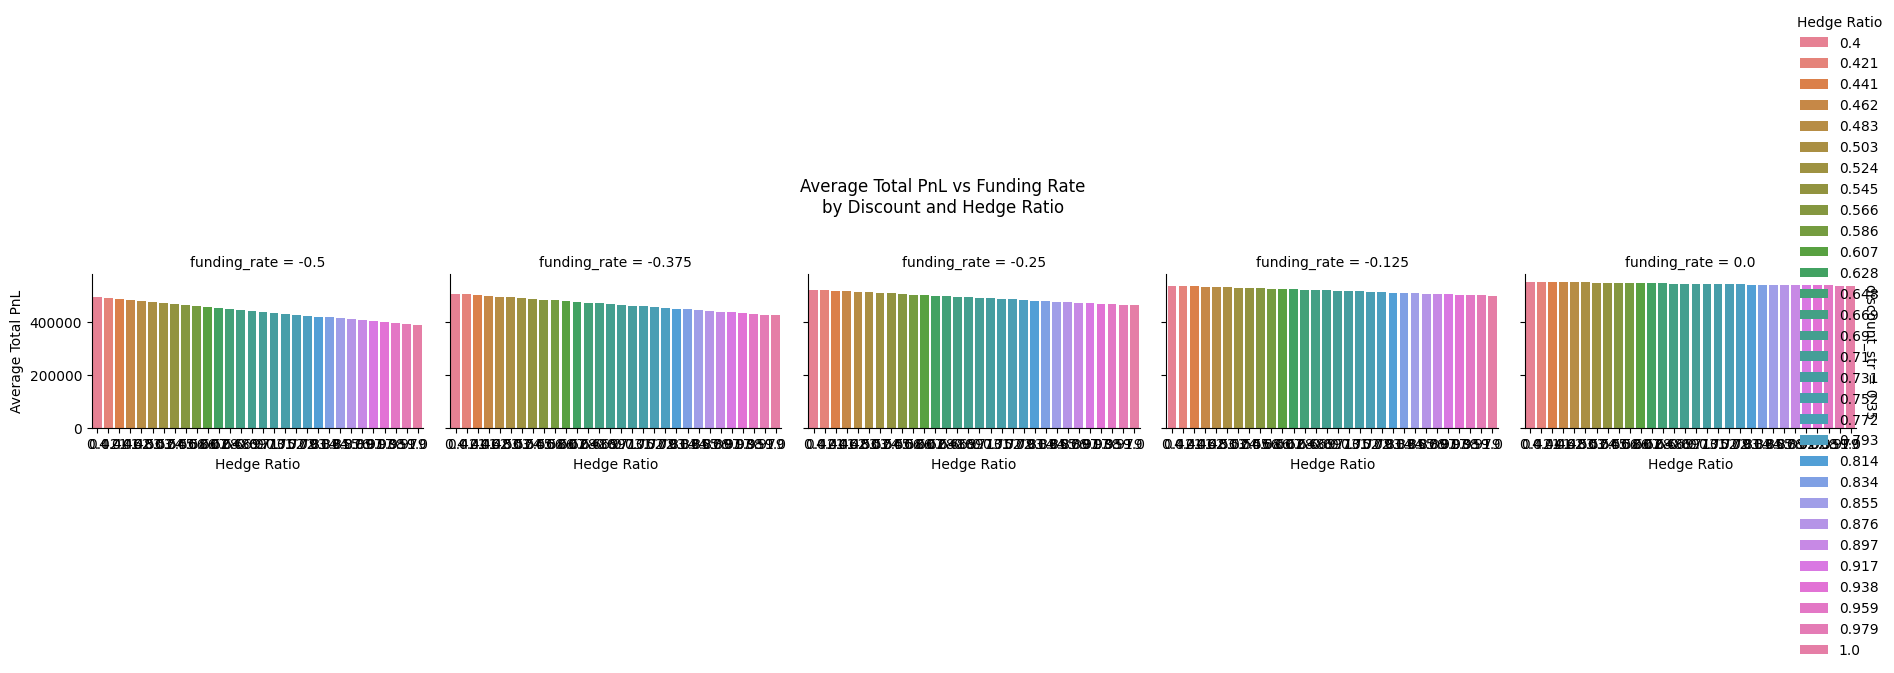

In [12]:
g2 = sns.FacetGrid(
    results_df,
    row="discount_str",
    col="funding_rate",
    hue="hedge_ratio_str",
    height=3,
    aspect=1.2,
    margin_titles=True
)
g2.map_dataframe(
    sns.barplot,
    x="hedge_ratio_str",
    y="avg_Total_PnL",
    order=sorted(results_df['hedge_ratio_str'].unique())
)
g2.add_legend(title="Hedge Ratio")
g2.set_axis_labels("Hedge Ratio", "Average Total PnL")
g2.fig.suptitle("Average Total PnL vs Funding Rate\nby Discount and Hedge Ratio", y=1.03)
plt.tight_layout()
plt.show()


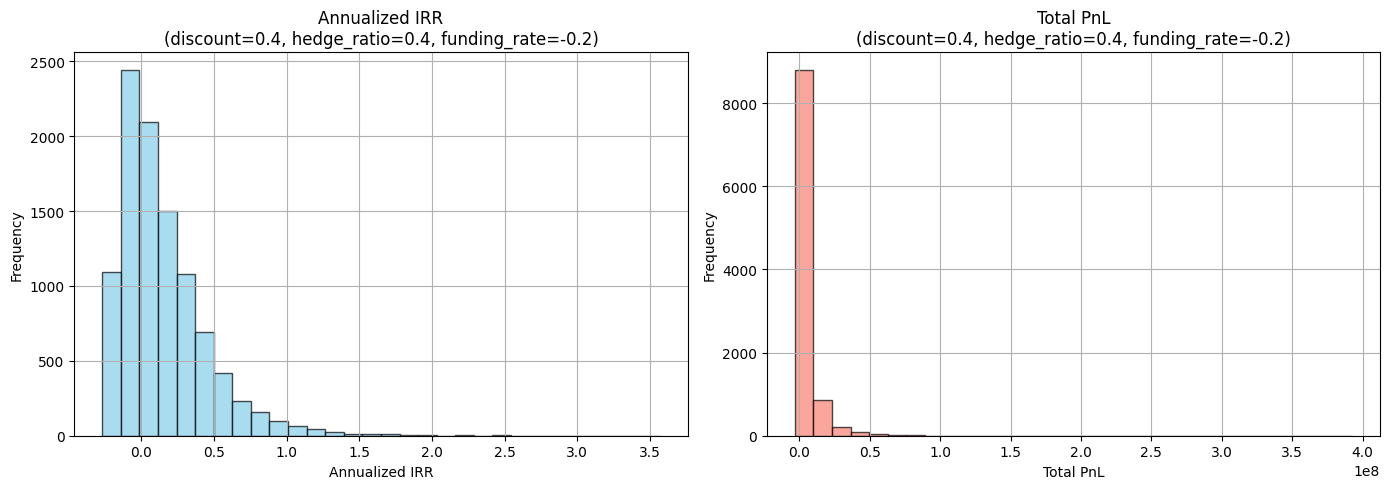

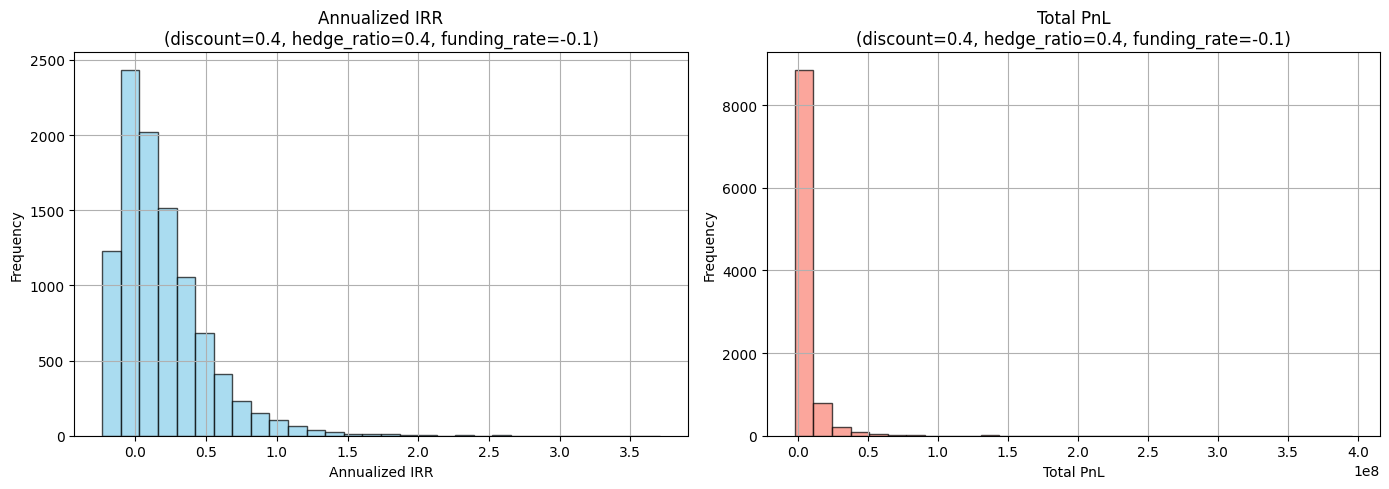

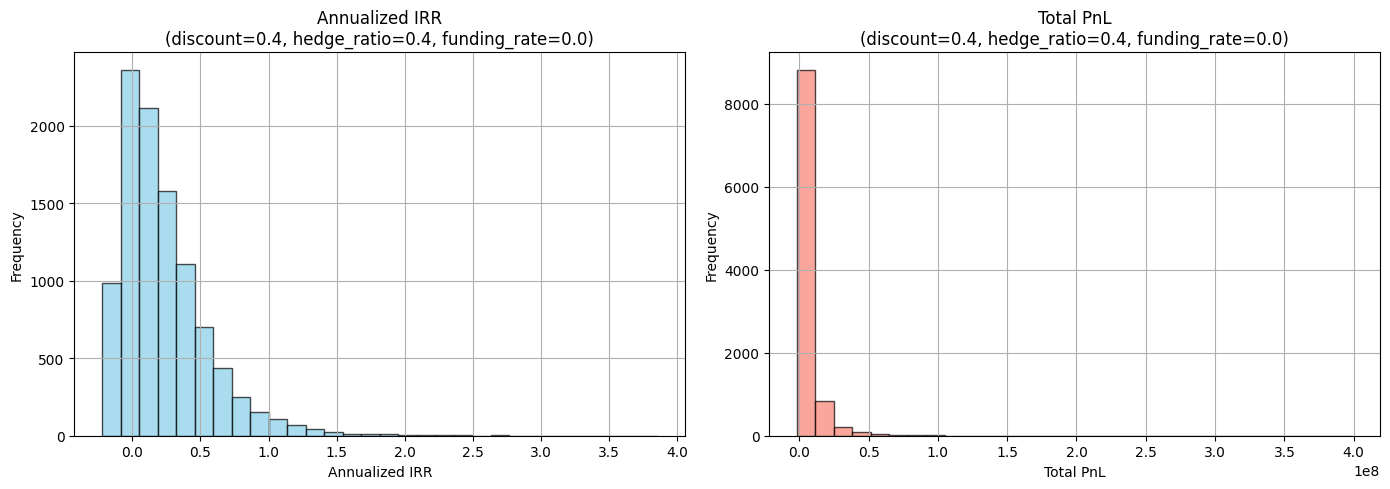

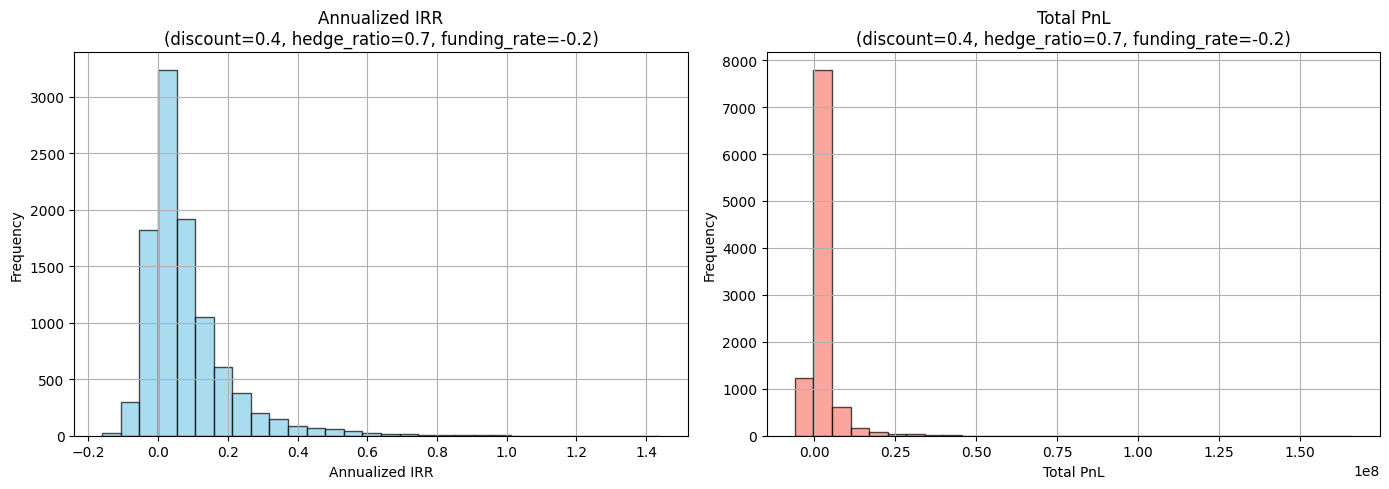

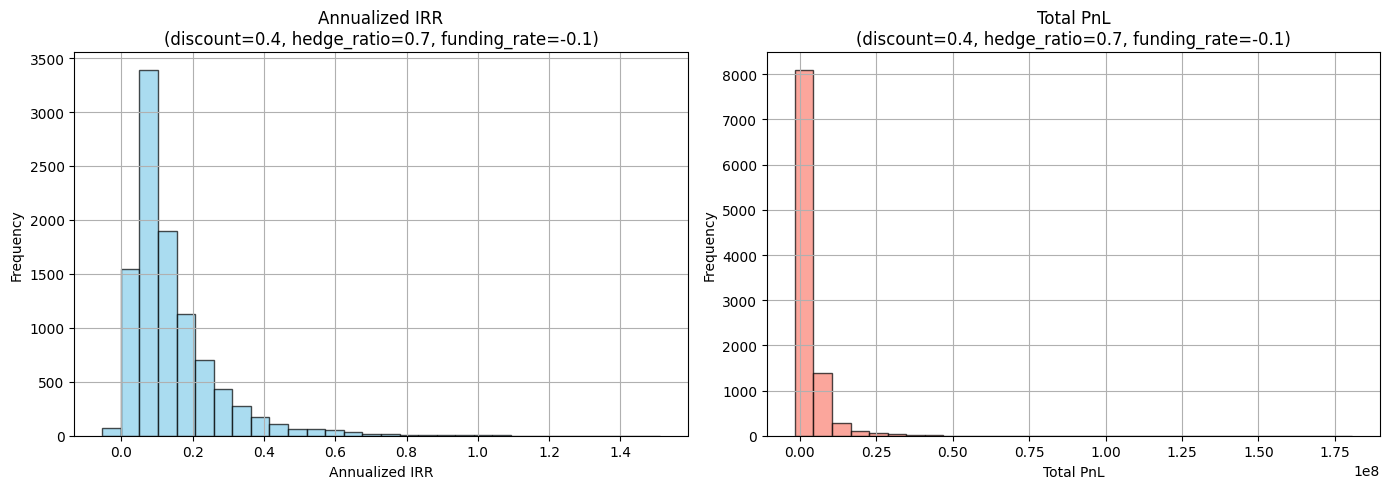

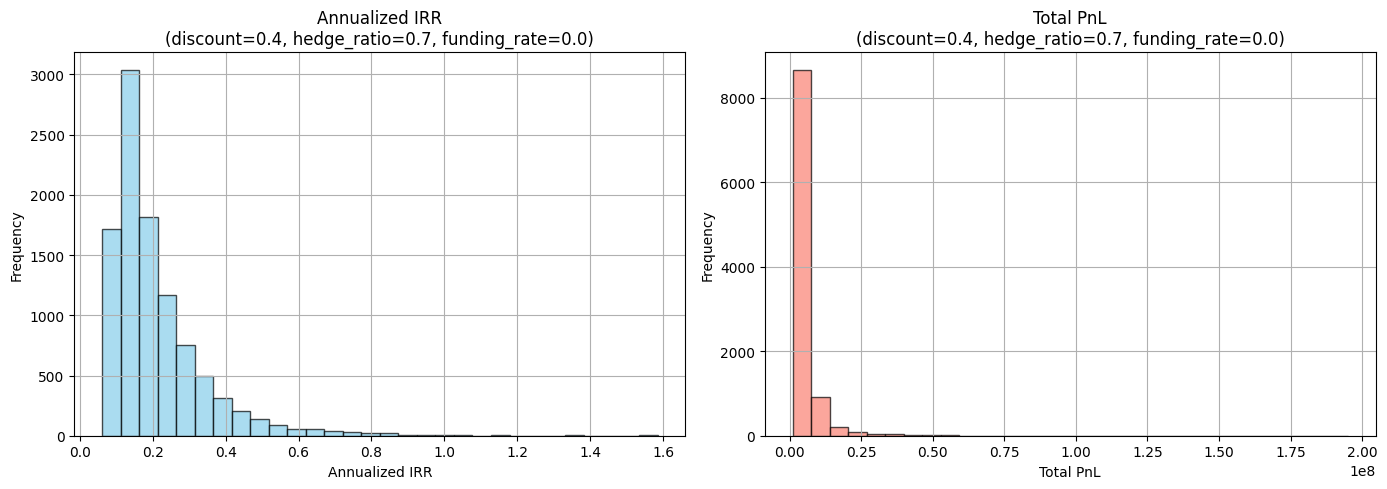

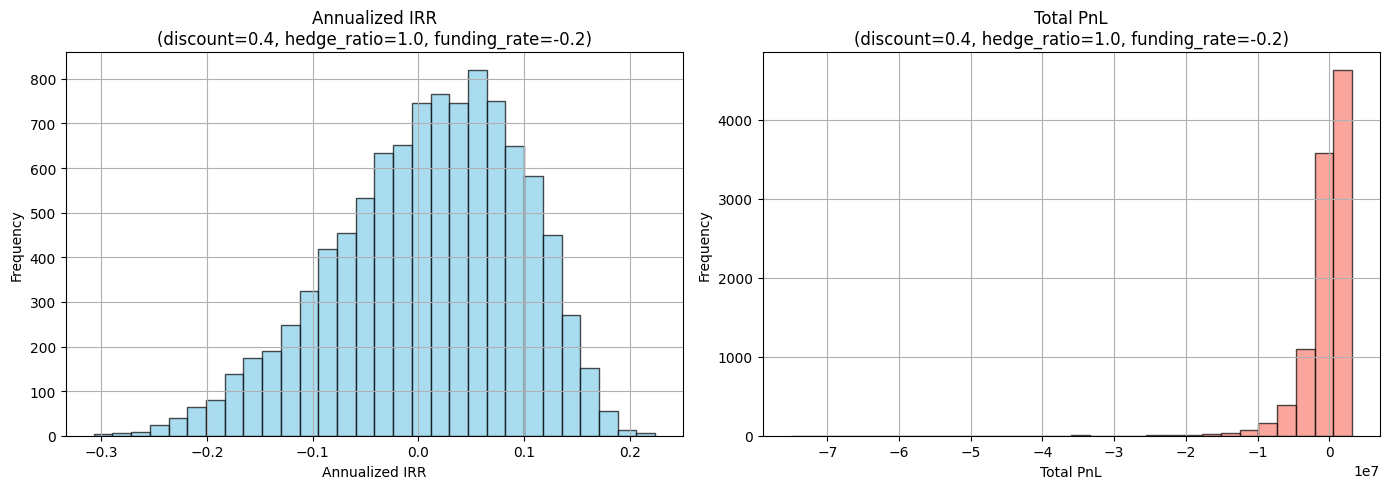

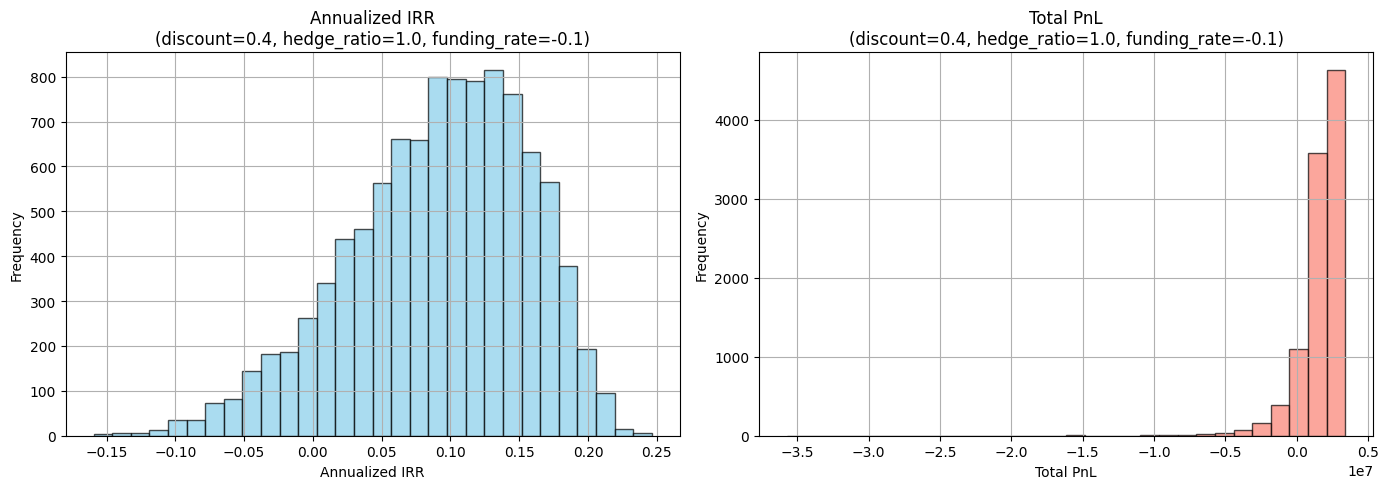

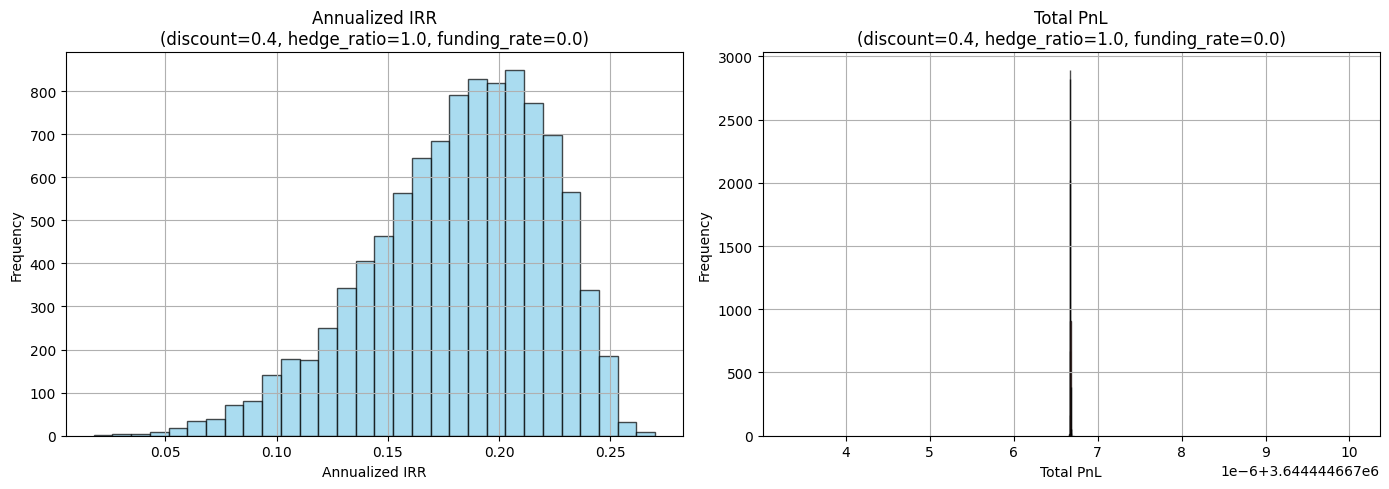

In [154]:
# Create histograms for each combination of parameters
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    
    # Only plot if the funding rate is 0.1 or 0.0
    if fund in [-0.2, -0.1, 0.0]:
        ann_irr_values = detailed_ann_irr[key]
        pnl_values = detailed_pnl[key]
        
        # Create a figure with two subplots: one for Annualized IRR and one for Total PnL
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot histogram for Annualized IRR
        ax1.hist(ann_irr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel("Annualized IRR")
        ax1.set_ylabel("Frequency")
        ax1.set_title(f"Annualized IRR\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax1.grid(True)
        
        # Plot histogram for Total PnL
        ax2.hist(pnl_values, bins=30, alpha=0.7, color='salmon', edgecolor='black')
        ax2.set_xlabel("Total PnL")
        ax2.set_ylabel("Frequency")
        ax2.set_title(f"Total PnL\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
        ax2.grid(True)
        
        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

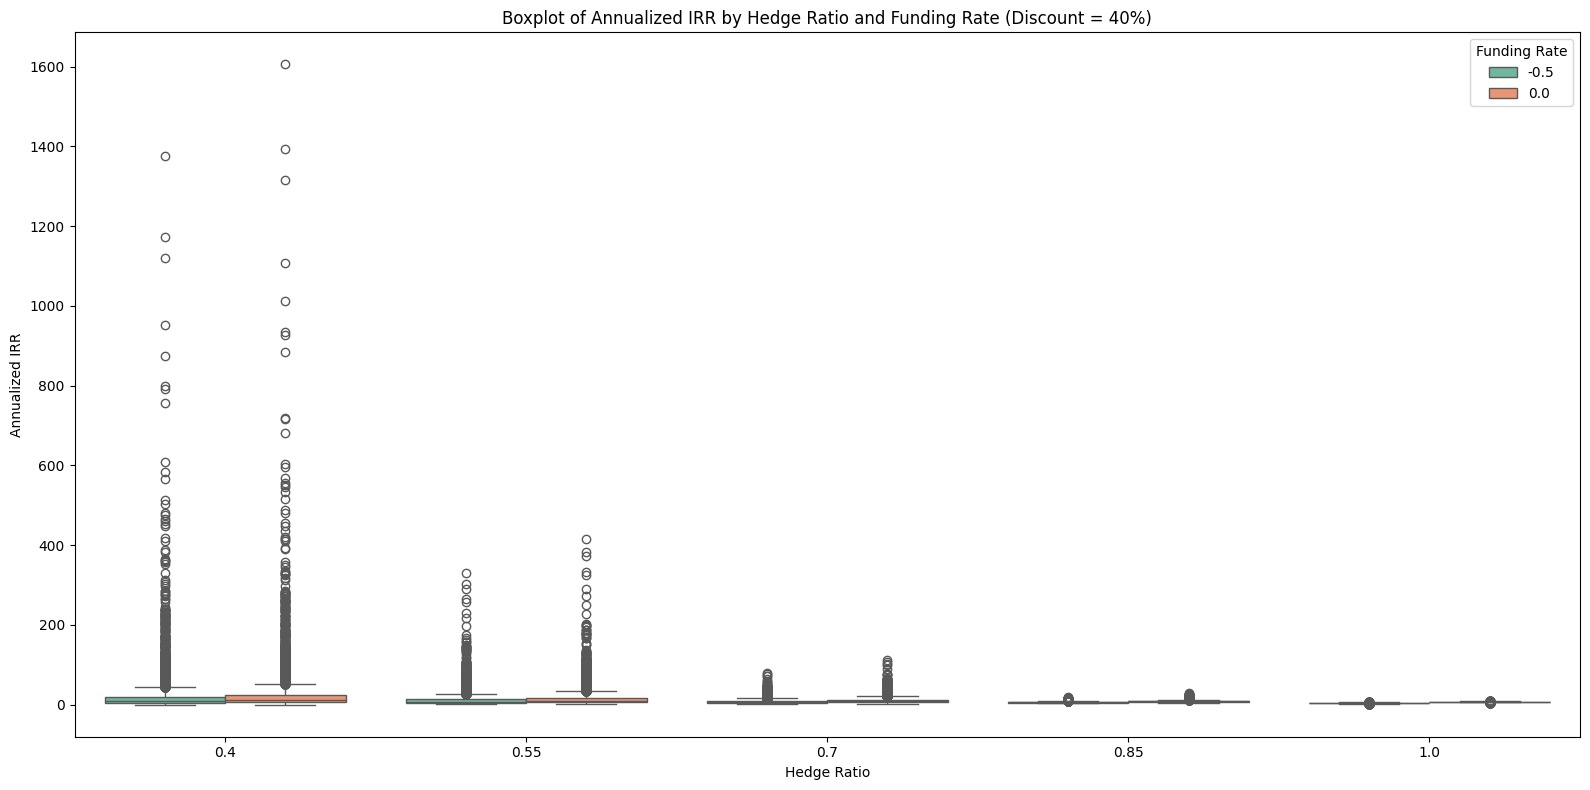

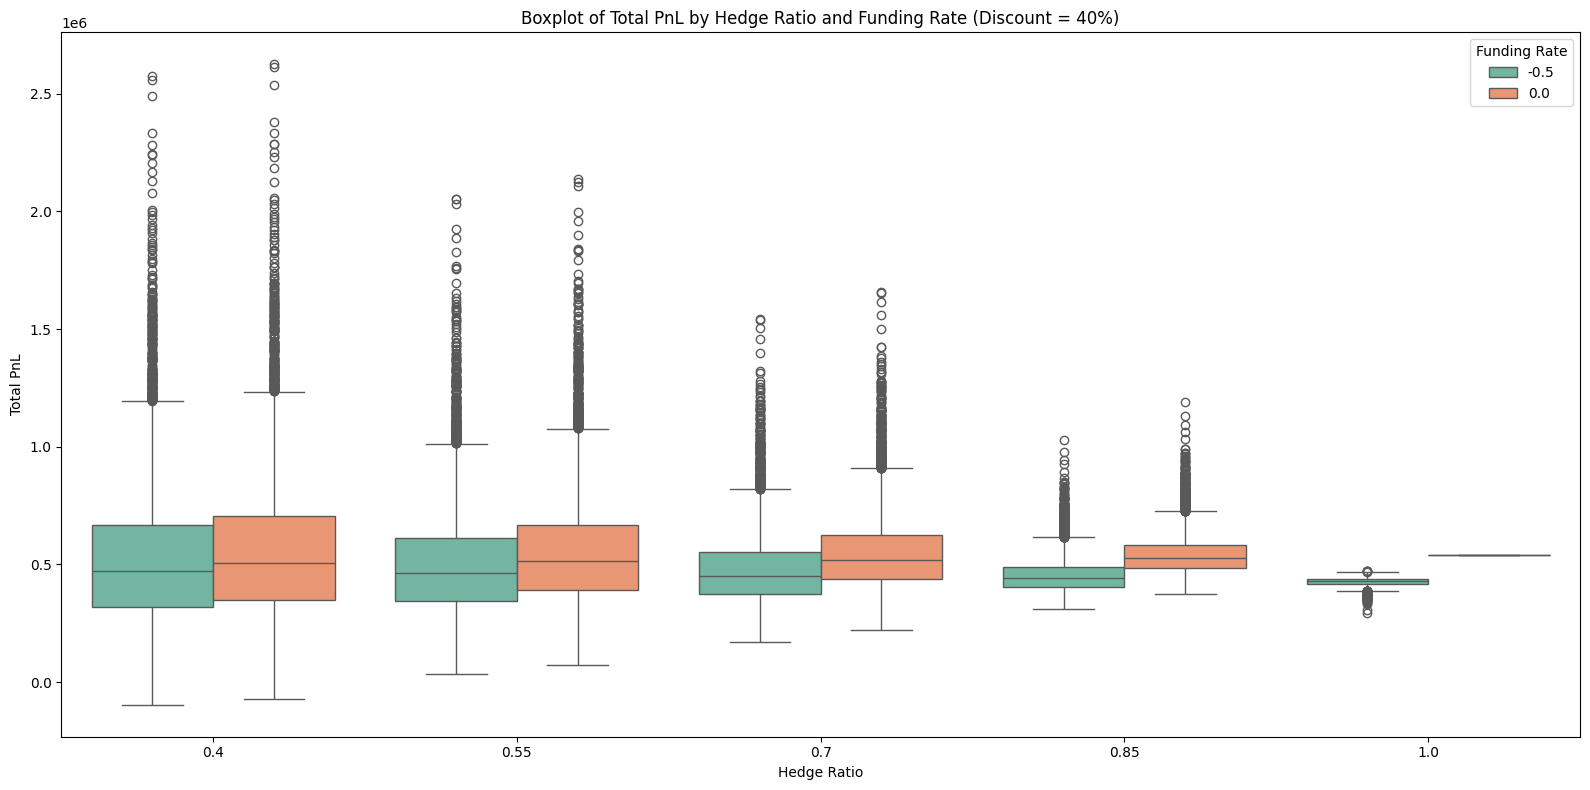

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for easier handling (flatten the dictionary)
all_results = []
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    ann_irr_values = detailed_ann_irr[key]
    pnl_values = detailed_pnl[key]
    
    # Add results to the DataFrame
    for ann_irr, pnl in zip(ann_irr_values, pnl_values):
        all_results.append({
            "discount": disc,
            "hedge_ratio": hedg,
            "funding_rate": fund,
            "Annualized_IRR": ann_irr,
            "Total_PnL": pnl
        })

# Convert to DataFrame
results_df_box = pd.DataFrame(all_results)

# Filter the DataFrame for 30% discount
results_df_box_filtered = results_df_box[results_df_box['discount'] == 0.35]

# Filter only for funding rates 0.0 and 0.1
results_df_box_filtered = results_df_box_filtered[results_df_box_filtered['funding_rate'].isin([-0.5, -0.4, -0.3, -0.2, -0.1, 0.0])]

# Set the figure size
plt.figure(figsize=(16, 8))

# Create a boxplot for Annualized IRR
sns.boxplot(x="hedge_ratio", y="Annualized_IRR", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=True)
plt.title("Boxplot of Annualized IRR by Hedge Ratio and Funding Rate (Discount = 40%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Annualized IRR")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()

# Create a boxplot for Total PnL
plt.figure(figsize=(16, 8))
sns.boxplot(x="hedge_ratio", y="Total_PnL", hue="funding_rate", data=results_df_box_filtered, 
            palette="Set2", showfliers=True)
plt.title("Boxplot of Total PnL by Hedge Ratio and Funding Rate (Discount = 40%)")
plt.xlabel("Hedge Ratio")
plt.ylabel("Total PnL")
plt.legend(title="Funding Rate")
plt.tight_layout()
plt.show()


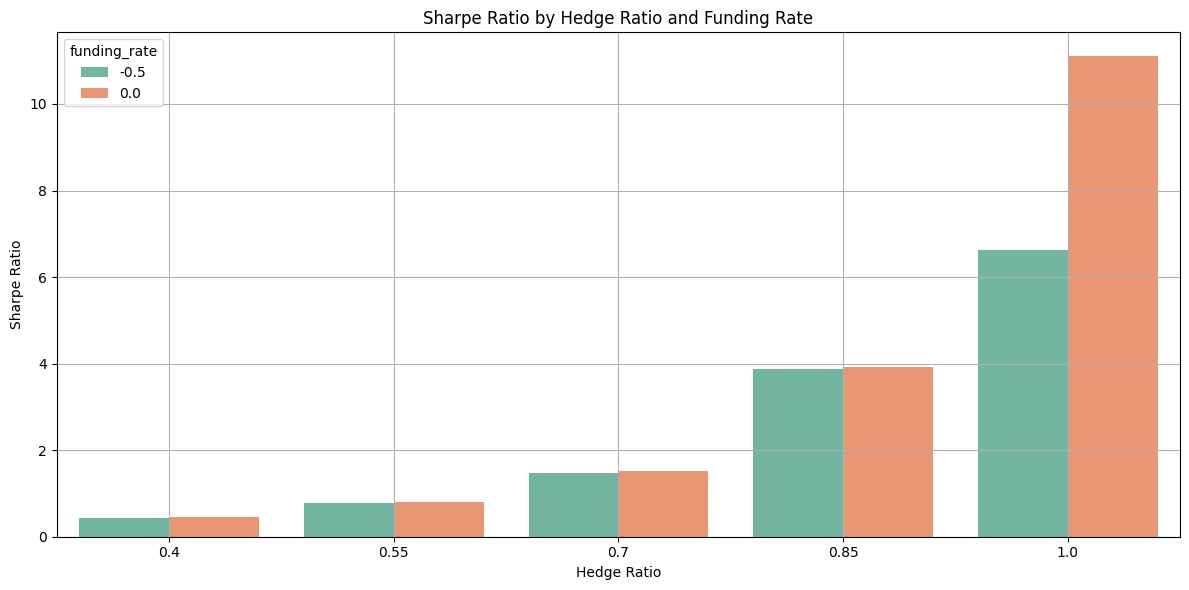

In [19]:
# Set your assumed risk-free rate
risk_free_rate = 0.0

# Group and calculate mean, std, and Sharpe ratio
sharpe_summary = results_df_box_filtered.groupby(["hedge_ratio", "funding_rate"]).agg(
    mean_irr=("Annualized_IRR", "mean"),
    std_irr=("Annualized_IRR", "std")
).reset_index()

# Calculate Sharpe Ratio
sharpe_summary["sharpe_ratio"] = (sharpe_summary["mean_irr"] - risk_free_rate) / sharpe_summary["std_irr"]
plt.figure(figsize=(12, 6))
sns.barplot(data=sharpe_summary, x="hedge_ratio", y="sharpe_ratio", hue="funding_rate", palette="Set2")
plt.title("Sharpe Ratio by Hedge Ratio and Funding Rate")
plt.xlabel("Hedge Ratio")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
import pandas as pd
from tabulate import tabulate

# Function to get the best hedge_ratio based on a given metric (e.g., avg IRR, median IRR, etc.)
def get_best_hedge_ratio(df, metric='median_total_PnL'):
    best_hedge_ratio = {}

    # Group by discount and funding rate to find the best hedge ratio for each combination
    for (discount, funding_rate) in df[['discount', 'funding_rate']].drop_duplicates().values:
        # Filter results for the given discount and funding rate
        discount_funding_group = df[(df['discount'] == discount) & (df['funding_rate'] == funding_rate)]
        
        # Get the best hedge ratio by selecting the row with the highest value for the given metric
        best_row = discount_funding_group.loc[discount_funding_group[metric].idxmax()]
        
        # Store the best hedge ratio
        best_hedge_ratio[(discount, funding_rate)] = best_row['hedge_ratio']
    
    return best_hedge_ratio

# Find the best hedge ratio based on the average IRR for each discount and funding rate
best_hedge_ratio_avg_irr = get_best_hedge_ratio(results_df, metric='median_Total_PnL')

# Convert the results into a DataFrame for easy display
best_hedge_ratio_df = pd.DataFrame.from_dict(best_hedge_ratio_avg_irr, orient='index', columns=['best_hedge_ratio'])

# Reset the index to separate discount and funding rate
best_hedge_ratio_df.reset_index(inplace=True)


# Use tabulate to print the results in a nice table format
print("Best Hedge Ratio Based on Median IRR for Each (Funding Rate, Discount) Combination:")
print(tabulate(best_hedge_ratio_df, headers='keys', tablefmt='psql', floatfmt=".2f"))

Best Hedge Ratio Based on Median IRR for Each (Funding Rate, Discount) Combination:
+----+----------------------------------------+--------------------+
|    | index                                  |   best_hedge_ratio |
|----+----------------------------------------+--------------------|
|  0 | (np.float64(0.35), np.float64(-0.5))   |               0.40 |
|  1 | (np.float64(0.35), np.float64(-0.375)) |               0.40 |
|  2 | (np.float64(0.35), np.float64(-0.25))  |               0.40 |
|  3 | (np.float64(0.35), np.float64(-0.125)) |               1.00 |
|  4 | (np.float64(0.35), np.float64(0.0))    |               1.00 |
+----+----------------------------------------+--------------------+


In [16]:
grouped_collateral = {}

# Group by hedge_ratio only
for key, collateral_paths in detailed_collateral.items():
    hedge_ratio = key[1]  # only using hedge ratio
    if hedge_ratio not in grouped_collateral:
        grouped_collateral[hedge_ratio] = []

    for path in collateral_paths:
        grouped_collateral[hedge_ratio].extend(path)

# Compute statistics per hedge ratio
stats_dict = {}
for hedge_ratio, coll_list in grouped_collateral.items():
    all_coll = np.array(coll_list)
    stats_dict[hedge_ratio] = {
        "Mean": np.mean(all_coll),
        "Median": np.median(all_coll),
        "Min": np.min(all_coll),
        "Max": np.max(all_coll),
        "Std": np.std(all_coll),
        "5th %ile": np.percentile(all_coll, 5),
        "95th %ile": np.percentile(all_coll, 95)
    }

# Convert to DataFrame
stats_df = pd.DataFrame(stats_dict).T
stats_df.index.name = "Hedge Ratio"

# Pretty print
print("Descriptive Statistics for Collateral (Grouped by Hedge Ratio):")
print(tabulate(stats_df, headers="keys", tablefmt="psql", floatfmt=".2f"))

Descriptive Statistics for Collateral (Grouped by Hedge Ratio):
+---------------+-----------+-----------+-----------+------------+-----------+------------+-------------+
|   Hedge Ratio |      Mean |    Median |       Min |        Max |       Std |   5th %ile |   95th %ile |
|---------------+-----------+-----------+-----------+------------+-----------+------------+-------------|
|          0.40 | 206640.89 | 205128.21 |  58037.06 |  836206.92 |  46614.45 |  140509.29 |   291697.42 |
|          0.42 | 217329.21 | 215738.28 |  61038.98 |  879459.00 |  49025.55 |  147777.01 |   306785.22 |
|          0.44 | 228017.54 | 226348.36 |  64040.90 |  922711.09 |  51436.64 |  155044.73 |   321873.02 |
|          0.46 | 238705.86 | 236958.44 |  67042.82 |  965963.17 |  53847.73 |  162312.45 |   336960.81 |
|          0.48 | 249394.22 | 247568.52 |  70044.73 | 1013347.88 |  56259.38 |  169580.17 |   352048.61 |
|          0.50 | 260082.85 | 258178.60 |  73046.65 | 1078226.00 |  58674.69 |  176847.9